In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Input, SimpleRNN, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from gensim.models import Word2Vec


/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Load the dataset
data = pd.read_csv('https://archive.ics.uci.edu/static/public/911/data.csv')


In [ ]:
# Preprocessing steps for the 'review_text' column
data['review_text'] = data['text'].str.lower()
data['review_text'] = data['review_text'].str.replace(r'[^\w\s]', '', regex=True)
data['review_text'] = data['review_text'].str.replace(r'\d+', '', regex=True)
data = data.dropna(subset=['review_text', 'best_score'])

# Categorize 'best_score' into 5 sentiment classes
def categorize_score(score):
    if score <= 189:  # Top 20% of 946
        return 0  # very negative
    elif score <= 378:  # Next 20%
        return 1  # negative
    elif score <= 567:  # Middle 20%
        return 2  # neutral
    elif score <= 756:  # Next 20%
        return 3  # positive
    else:
        return 4  # very positive

# Apply categorization
data['classified_sentiments'] = data['best_score'].apply(categorize_score)


In [6]:
# Word2Vec Embedding
sentences = data['review_text'].apply(lambda x: x.split()).tolist()
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Create an embedding matrix
vocab_size = len(word2vec_model.wv)+1
embedding_matrix = np.zeros((vocab_size, 100))
word_index = {word: idx + 1 for idx, word in enumerate(word2vec_model.wv.index_to_key)}
for word, idx in word_index.items():
    embedding_matrix[idx] = word2vec_model.wv[word]

# Split data
X_train, X_test, y_train, y_test = train_test_split(data['review_text'], data['classified_sentiments'], test_size=0.2, random_state=42)


In [7]:

# Tokenization for RNN and BiRNN
def texts_to_sequences(texts, word_index):
    return [[word_index.get(word, 0) for word in text.split()] for text in texts]

X_train_seq = texts_to_sequences(X_train, word_index)
X_test_seq = texts_to_sequences(X_test, word_index)
X_train_pad = tf.keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen=200)
X_test_pad = tf.keras.preprocessing.sequence.pad_sequences(X_test_seq, maxlen=200)

# Build Simple RNN model using Sequential API
rnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=200, weights=[embedding_matrix], trainable=False),
    SimpleRNN(64, return_sequences=False, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

rnn_optimizer = Adam(learning_rate=0.001)
rnn_model.compile(optimizer=rnn_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train Simple RNN model
rnn_model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test))


Epoch 1/5


/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


455/455 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7509 - loss: 0.9143 - val_accuracy: 0.7965 - val_loss: 0.7149
Epoch 2/5
455/455 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7935 - loss: 0.7585 - val_accuracy: 0.7965 - val_loss: 0.7218
Epoch 3/5
455/455 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7919 - loss: 0.7340 - val_accuracy: 0.7965 - val_loss: 0.7074
Epoch 4/5
455/455 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7917 - loss: 0.7110 - val_accuracy: 0.7965 - val_loss: 0.7052
Epoch 5/5
455/455 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7953 - loss: 0.7055 - val_accuracy: 0.7965 - val_loss: 0.7009


In [8]:

# Build BiRNN model using Sequential API
birnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=200, weights=[embedding_matrix], trainable=False),
    Bidirectional(LSTM(64, return_sequences=False, activation='tanh')),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

birnn_optimizer = RMSprop(learning_rate=0.001)
birnn_model.compile(optimizer=birnn_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train BiRNN model
birnn_model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test))


Epoch 1/5
455/455 ━━━━━━━━━━━━━━━━━━━━ 29s 61ms/step - accuracy: 0.7818 - loss: 0.7722 - val_accuracy: 0.7965 - val_loss: 0.7061
Epoch 2/5
455/455 ━━━━━━━━━━━━━━━━━━━━ 31s 69ms/step - accuracy: 0.7982 - loss: 0.6949 - val_accuracy: 0.7962 - val_loss: 0.6879
Epoch 3/5
455/455 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step - accuracy: 0.7957 - loss: 0.6998 - val_accuracy: 0.7959 - val_loss: 0.6864
Epoch 4/5
455/455 ━━━━━━━━━━━━━━━━━━━━ 31s 69ms/step - accuracy: 0.7982 - loss: 0.6789 - val_accuracy: 0.7959 - val_loss: 0.6845
Epoch 5/5
455/455 ━━━━━━━━━━━━━━━━━━━━ 31s 69ms/step - accuracy: 0.7954 - loss: 0.6889 - val_accuracy: 0.7957 - val_loss: 0.6856


In [9]:

# Evaluation Function
def evaluate_model(model, X_test, y_test, model_type="RNN"):
    predictions = model.predict(X_test)
    y_pred = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['very negative', 'negative', 'neutral', 'positive', 'very positive'])
    print(f"Accuracy ({model_type}): {accuracy}")
    print(f"Classification Report ({model_type}):\n{report}")

# Evaluate Simple RNN
evaluate_model(rnn_model, X_test_pad, y_test, model_type="Simple RNN")

# Evaluate BiRNN
evaluate_model(birnn_model, X_test_pad, y_test, model_type="BiRNN")


114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Accuracy (Simple RNN): 0.7964796479647965
Classification Report (Simple RNN):
               precision    recall  f1-score   support

very negative       0.80      1.00      0.89      2896
     negative       0.00      0.00      0.00       524
      neutral       0.00      0.00      0.00        68
     positive       0.00      0.00      0.00        91
very positive       0.00      0.00      0.00        57

     accuracy                           0.80      3636
    macro avg       0.16      0.20      0.18      3636
 weighted avg       0.63      0.80      0.71      3636

  1/114 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step

/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Accuracy (BiRNN): 0.7956545654565457
Classification Report (BiRNN):
               precision    recall  f1-score   support

very negative       0.80      1.00      0.89      2896
     negative       0.00      0.00      0.00       524
      neutral       0.00      0.00      0.00        68
     positive       0.00      0.00      0.00        91
very positive       0.00      0.00      0.00        57

     accuracy                           0.80      3636
    macro avg       0.16      0.20      0.18      3636
 weighted avg       0.63      0.80      0.71      3636



/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [3]:
pip install keras-tuner

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

num_classes = len(np.unique(y))

# Define the model-building function for hyperparameter tuning
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_input', min_value=64, max_value=256, step=64),
        activation='relu',
        input_dim=X_train.shape[1]
    ))
    model.add(Dropout(hp.Float('dropout_input', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(
        units=hp.Int('units_hidden', min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_hidden', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['f1_score']
    )
    return model

# Initialize the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',  # Change to 'val_accuracy' as metrics like 'f1_score' may not be supported natively
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='hyperparameter_tuning'
)

# Perform the search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test_pad, y_test), batch_size=32)

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=10, validation_data=(X_test_pad, y_test), batch_size=32)

PermissionDeniedError: my_dir; Read-only file system

FCNN: stars as y

/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch 1/5


/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8232 - loss: 0.7506 - val_accuracy: 0.8392 - val_loss: 0.4704
Epoch 2/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8421 - loss: 0.4575 - val_accuracy: 0.8414 - val_loss: 0.4547
Epoch 3/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8711 - loss: 0.3500 - val_accuracy: 0.8465 - val_loss: 0.5005
Epoch 4/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9135 - loss: 0.2332 - val_accuracy: 0.8444 - val_loss: 0.7580
Epoch 5/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9331 - loss: 0.1692 - val_accuracy: 0.8435 - val_loss: 0.7714
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.11      0.17        63
           1       0.30      0.07      0.12        41
           2       0.36      0.23      0.28        98
           3       0.37      0.21      0.27       328
           4       0.89      0.97  

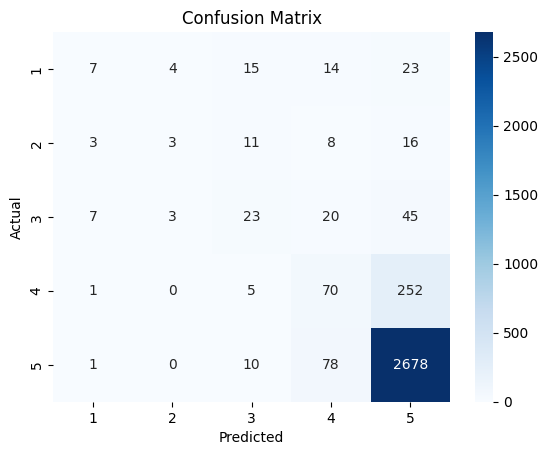

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/richard2323233/schulich_data_science/refs/heads/main/Recipe%20Reviews%20and%20User%20Feedback%20Dataset.csv')

# Prepare features and target
df = df.dropna(subset=['text'])  # Remove rows with missing text
X = df['text']
y = df['stars']

# Preprocess text data
max_words = 10000
max_len = 200
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_seq, maxlen=max_len, padding='post')

# Encode target labels
y = y - 1  # Assuming star ratings are from 1 to 5, we shift them to 0 to 4 for zero-based indexing

# Filter out invalid label values
valid_indices = y >= 
X_padded = X_padded[valid_indices]
y = y[valid_indices]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Build FCNN model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # 5 classes for star ratings 1 to 5
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64)

# Evaluate the model
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the model-building function for hyperparameter tuning
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_input', min_value=64, max_value=256, step=64),
        activation='relu',
        input_dim=X_train.shape[1]
    ))
    model.add(Dropout(hp.Float('dropout_input', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(
        units=hp.Int('units_hidden', min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_hidden', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['f1_score']
    )
    return model

# Initialize the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',  # Change to 'val_accuracy' as metrics like 'f1_score' may not be supported natively
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='hyperparameter_tuning'
)

# Perform the search
tuner.search(X_train, y_train_categorical, epochs=10, validation_split=0.2, batch_size=32)

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train_categorical, epochs=10, validation_split=0.2, batch_size=32)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Attention, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/richard2323233/schulich_data_science/refs/heads/main/Recipe%20Reviews%20and%20User%20Feedback%20Dataset.csv')

# Prepare features and target
df = df.dropna(subset=['text'])  # Remove rows with missing text
X = df['text']
y = df['stars']

# Preprocess text data
max_words = 10000
max_len = 200
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_seq, maxlen=max_len, padding='post')

# Encode target labels
y = y - 1  # Assuming star ratings are from 1 to 5, we shift them to 0 to 4 for zero-based indexing

# Filter out invalid label values
valid_indices = y >= 0
X_padded = X_padded[valid_indices]
y = y[valid_indices]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Build BiRNN model with attention
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=max_words, output_dim=128, input_length=max_len)(input_layer)
birnn_layer = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)

# Attention mechanism
attention_layer = Attention()([birnn_layer, birnn_layer])
from tensorflow.keras.layers import Lambda

context_vector = Lambda(lambda x: tf.reduce_sum(x, axis=1))(attention_layer)
dense_layer = Dense(128, activation='relu')(context_vector)
dropout_layer = Dropout(0.5)(dense_layer)
output_layer = Dense(5, activation='softmax')(dropout_layer)  # 5 classes for star ratings 1 to 5

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64)

# Evaluate the model
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()